# Brain Signal Decoding (Real Neuroscience Data)
Imad Albekai

In order to understand the way the brain encodes sensory information, we need to find a relation between the stimulus and the measured brain response. The brain is always active as it handles a plethora of information related to different functions both internal and external.

We will deal with data measured during visual stimulation experiments and investigate areas in the brain that respond to these visual images.

In [ ]:
# @markdown [Prep] Run this cell to load data and install libraries
# data download and library installation
# Generic object decoding data
!wget -q -O data.h5 https://ndownloader.figshare.com/files/15049646
# Generic object decoding features
# !wget -q -O features.h5 https://ndownloader.figshare.com/files/15015971
# # Download ImageNet labels
# !wget -q -O imagenet_classes.txt https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

!pip install -q bdpy
!pip install -q seaborn_image

In [ ]:
# @markdown Include required libraries
import bdpy
from bdpy.util import get_refdata
import numpy as np
import pandas as pd
import seaborn_image as isns
import seaborn as sns
import ipywidgets as widgets  # interactive display
import matplotlib.pyplot as plt
from random import seed
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
import urllib
from PIL import Image
from torchvision import transforms
import torch

In [ ]:
rois = {'VC' : 'ROI_VC = 1',
        'LVC' : 'ROI_LVC = 1',
        'HVC' : 'ROI_HVC = 1',
        'V1' : 'ROI_V1 = 1',
        'V2' : 'ROI_V2 = 1',
        'V3' : 'ROI_V3 = 1',
        'V4' : 'ROI_V4 = 1',
        'LOC' : 'ROI_LOC = 1',
        'FFA' : 'ROI_FFA = 1',
        'PPA' : 'ROI_PPA = 1'}

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_id)
    seed(worker_id)

## Part 1: Classification Models

### Generalized Linear Models (GLM)


#### Linear Regression

(np.float64(-3.671968539277525),
 np.float64(3.1355013311970175),
 np.float64(-4.680100913238944),
 np.float64(4.825727471021255))

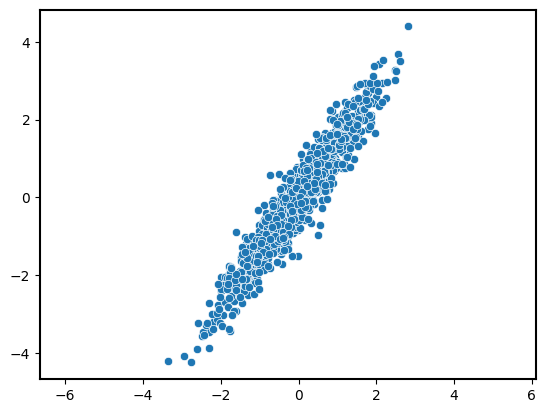

In [ ]:
# Simulate linear dependency

# Generate 1000 points randomly
x1 = np.random.normal(size=1000)
noise = np.random.normal(scale=0.3, size=1000)
y1 = 1.5 * x1
x1 = x1 + noise
sns.scatterplot(x=x1, y=y1)
plt.axis('equal')

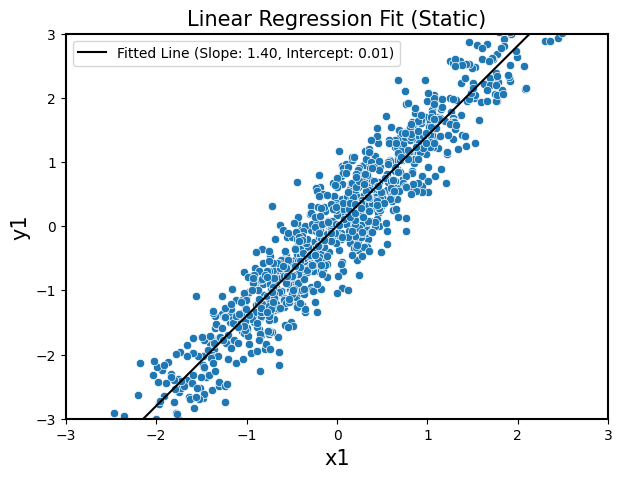

In [ ]:
my_layout = widgets.Layout()

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    slope=widgets.FloatSlider(0., min=-3., max=3., step=.1,
                               layout=my_layout),
    offset=widgets.FloatSlider(0., min=-3., max=3., step=0.2,
                                layout=my_layout)
)

def diff_DC(slope=200., offset=10.):
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
  sns.scatterplot(x=x1, y=y1, ax=axes[0])
  x_data = np.array([-3, 3])

  y_data = x_data * slope + offset
  sns.lineplot(x=x_data, y=y_data, ax=axes[0], color='k')
  axes[0].axis('equal')
  axes[0].set_xlim(-3, 3)
  axes[0].set_ylim(-3, 3)

  error = np.square(y1 - (x1 * slope + offset))
  axes[1].stem(x1, error, use_line_collection=True)
  axes[1].set_ylim(0, 5)
  plt.show()

#### Logistic Regression

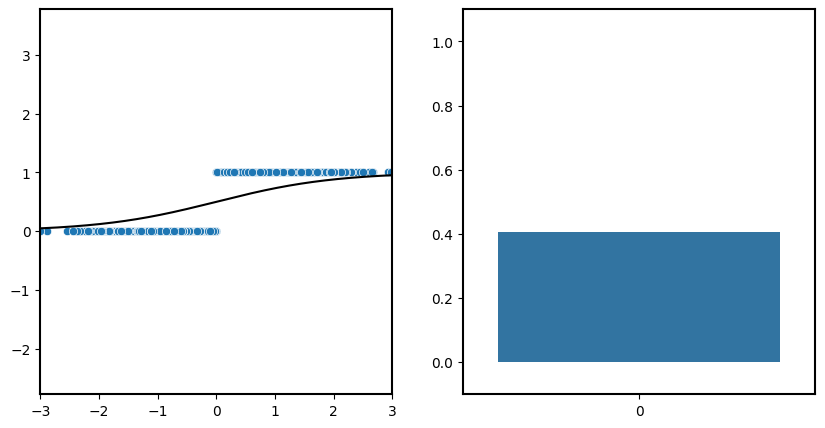

In [ ]:
# Logistic regression
x1 = np.random.normal(size=1000)
# noise = np.random.normal(scale=0.3, size=1000)
y1 = 1.5 * x1
y1_binary = (y1 > 0.0).astype(float)

my_layout = widgets.Layout()

def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    slope=widgets.FloatSlider(1., min=0., max=10., step=.1,
                               layout=my_layout),
    offset=widgets.FloatSlider(0., min=-3., max=3., step=0.2,
                                layout=my_layout)
)



def diff_DC(slope=0., offset=0.):
  fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
  sns.scatterplot(x=x1, y=y1_binary, ax=axes[0])
  x_data = np.linspace(-3, 3, 1000)

  y_data = 1 / (1 + np.exp(-(x_data * slope + offset)))

  sns.lineplot(x=x_data, y=y_data, ax=axes[0], color='k')
  axes[0].axis('equal')
  axes[0].set_xlim(-3, 3)
  axes[0].set_ylim(-0.1, 1.1)

  error = BinaryCrossEntropy(y1_binary, 1 / (1 + np.exp(-(x1 * slope + offset))))
  sns.barplot(x=[0], y=[error], ax=axes[1])
  axes[1].set_ylim(-0.1, 1.1)
  plt.show()


By moving the sliders, you are modifying the parameters of the linear regression model to produce the model that most likely has generated the data. This case of one input and one output is trivial but usually you will get multiple input variables for the output with some of the inputs related to the output to different degrees and some not related at all. The question here is how to tune your model to have the correct attributions between inputs and outputs and how to automate the process. One way to do that is to find the error between the real output features and the predicted output features of the model and try to minimize that. This loss is called mean squared error loss and is used predominantly in linear regression:

$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \hat{y}_i \right)^2$$


While for logistic regression, binary cross entropy function is used instead:


$$\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$


Minimizing the loss function can be achieved by multiple ways such as gradient descent. This is readily implemented in scikit learn for you as follows.

In [ ]:
linear_model = LinearRegression()
linear_model.fit(np.expand_dims(x1, axis=1), y1)
print(linear_model.coef_)

[1.39787727]


You can see the predicted weight is very close to the real one.

Now let’s consider a case of fewer points and three inputs. You can now tune four parameters. In this condition, we want to test the quality of our model so we hide some points (test set) and you should tune the parameters on the visible points only (training set). First, imaging that the output is only dependent on x1 and observe the model.

In [ ]:
seed_worker(0)

x1 = np.random.normal(size=10)
noise1 = np.random.normal(scale=1, size=10)
x2 = np.random.normal(size=10)
noise2 = np.random.normal(scale=1, size=10)
x3 = np.random.normal(size=10, scale=1)
noise3 = np.random.normal(scale=1, size=10)
y1 = 0.9 * x1 + 0.4 * x2
x1 = x1 + noise1
x2 = x2 + noise2
x3 = x3 + noise3

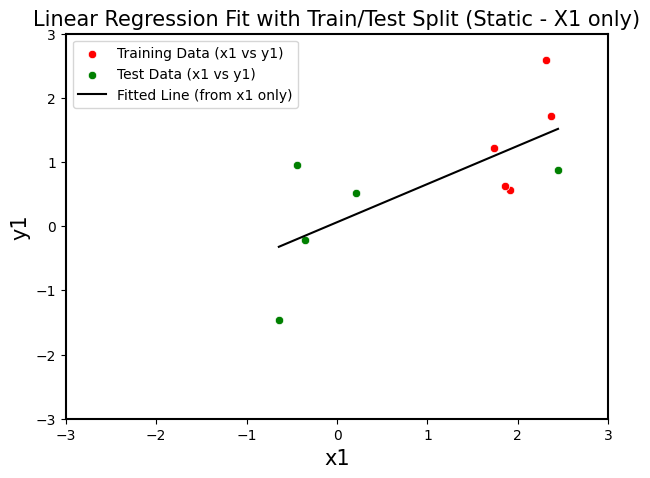

In [ ]:
my_layout = widgets.Layout()

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    beta0=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                               layout=my_layout),
    beta1=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                               layout=my_layout),
    beta2=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                               layout=my_layout),
    beta3=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                                layout=my_layout),
    proportion_train=widgets.FloatSlider(0.3, min=0., max=100., step=10.,
                                layout=my_layout),
    flag_m=widgets.Checkbox(value=False, description='show_test', disabled=False, indent=False)
)

def diff_DC(beta0=0., beta1=0., beta2=0.,
            beta3=0., proportion_train=0.5, flag_m=False):
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
  number_of_train_points = int(proportion_train * x1.shape[0])
  sns.scatterplot(x=x1[:number_of_train_points],
                  y=y1[:number_of_train_points],
                  ax=axes[0], color='r')
  if flag_m:
    sns.scatterplot(x=x1[number_of_train_points:],
                  y=y1[number_of_train_points:],
                  ax=axes[0], color='g')
  x_data = x1

  y_data = x1 * beta1 + x2 * beta2 + x3 * beta3 + beta0
  sns.lineplot(x=x_data, y=y_data, ax=axes[0], color='k')
  axes[0].axis('equal')
  axes[0].set_xlim(-3, 3)
  axes[0].set_ylim(-3, 3)

  error = np.abs(y1 - y_data)
  axes[1].stem(x1[:number_of_train_points], error[:number_of_train_points], linefmt='red', markerfmt='ro', use_line_collection=True)
  if flag_m:
    axes[1].stem(x1[number_of_train_points:], error[number_of_train_points:], linefmt='green', markerfmt='go', use_line_collection=True)
  axes[1].set_ylim(0, 5)
  plt.show()

In [ ]:
# Prepare training and test sets
X = np.vstack((x1, x2, x3)).T
X_train = X[:3, :]
X_test = X[3:, :]
y_train = y1[:3]
y_test = y1[3:]

# Try these parameters in the widget
print(np.linalg.inv(X_train).dot(y1[:3]))

[-0.14301916  0.19111806 -0.66751113]





Now let’s consider the case that all the inputs have an association with the model and try to minimize the error in the training set.

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print(linear_model.coef_)

[-0.10807557  0.19301173 -0.67258269]




L1 loss function:

$$
\text{Loss} = \text{Error}(y, \hat{y}) + \lambda \sum_{i=1}^{N} \left| w_i \right|
$$


L2 loss function:

$$
\text{Loss} = \text{Error}(y, \hat{y}) + \lambda \sum_{i=1}^{N} w_i^2
$$


Where λ controls the amount of regularization.

In [ ]:
linear_model = Ridge()
linear_model.fit(X_train, y_train)
print(linear_model.coef_)

[-0.03698999  0.08952323 -0.22143761]


What do you observe?

##### Logistic Regression using sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression
x1 = np.random.normal(size=1000)
y1 = 1.5 * x1 + np.random.normal(scale=0.5, size=1000)
y1_binary = (y1 > 0.0).astype(float)
x1 = np.expand_dims(x1, 1)
linear_model = LogisticRegression()
linear_model.fit(x1, y1_binary.squeeze())

LogisticRegression()

### Explore data
Now let’s look at real brain data. We will be using data from the paper (horikawa et al paper). The dataset contains a large amount of fMRI data of images shown to subjects. Some of those images are repeatedly shown to the subject while others are shown once but different images having the same main objects (note: those images are not necessarily the ones in the dataset):

Similar: Gold fish category

<img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/> <img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/> <img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/>

Different: Cat category

<img src="https://drive.google.com/uc?id=1vSehKdq7Tl_gsUxc4xLOuSXYxF-VjJkd" alt="drawing" height="100"/> <img src="https://drive.google.com/uc?id=1FhEotidDDc9jnR-tWX4EMUXqZr0Avam4" alt="drawing" height="100"/> <img src="https://drive.google.com/uc?id=1hnbpYWpkymEOi_FWb5XxLq2pG4j53TAc" alt="drawing" height="100"/>

We will look at the data from one of the subjects. We will be using the Brain Decoding Toolbox library for loading the data since it makes dealing with the data very easy (Also the dataset is available to be loaded directly into this format).

In [ ]:
!pip install git+https://github.com/KamitaniLab/brain-decoding-datasets.git

| Key            | Description                                                                       |
|----------------|-----------------------------------------------------------------------------------|
| DataType       | 1 = Data type (1 = Training data; 2 = Perception test data; 3 = Imagery test data |
| Run            | 1 = Run number                                                                    |
| Label          | 1 = Label (image ID)                                                              |
| VoxelData      | 1 = Voxel data                                                                    |
| voxel_x        | Voxel x coordinate                                                                |
| voxel_y        | Voxel y coordinate                                                                |
| voxel_z        | Voxel z coordinate                                                                |
| VolInds        | 1 = Volume index                                      

You now have brain data from different regions in the visual cortex corresponding to subjects watching visual stimuli. We made the following function to  extract data belonging to two different images to build a binary classifier.

In [ ]:
# data extraction functions
def extract_data(roi, image_type='similar', number_of_categories=2):
  filename = 'data.h5'
  data = bdpy.BData(filename)
  voxel_data = data.select(rois[roi])
  data_type = data.select('DataType')
  data_labels = data.select('stimulus_id')
  if image_type == 'similar':
    data_filter = (data_type == 2).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  elif image_type == 'different':
    data_filter = (data_type == 1).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  elif image_type == 'imagery':
    data_filter = (data_type == 3).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  data_labels = np.floor(data_labels).astype(int)

  unique_data_labels = np.unique(data_labels)
  unique_data_labels_filtered = unique_data_labels[:number_of_categories]
  data_label_filter = [True if label in list(unique_data_labels_filtered) else False for label in data_labels]

  voxel_data = voxel_data[data_label_filter, :]
  data_labels = data_labels[data_label_filter, :]


  return voxel_data, data_labels


In [ ]:
X, y = extract_data('LOC', image_type='similar')
print(X.shape)
print(y.shape)

(70, 540)
(70,)


### Multivariate Pattern Analysis (MVPA)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = LogisticRegression(penalty='l2')
# do a training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# calculate accuracy
print(accuracy_score(y_test, y_pred))

0.5714285714285714


In [ ]:
roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
accuracy = pd.DataFrame(index=roi_list, columns=['accuracy'])
for roi in roi_list:
  X, y = extract_data(roi, image_type='similar')

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy.loc[roi, 'accuracy'] = accuracy_score(y_test, y_pred)

accuracy.plot(kind='bar')

In [ ]:
roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
accuracy = pd.DataFrame(index=roi_list, columns=['accuracy'])
for roi in roi_list:
  X, y = extract_data(roi, image_type='different')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy.loc[roi, 'accuracy'] = accuracy_score(y_test, y_pred)

accuracy.plot(kind='bar')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
model = LogisticRegression(penalty='l2')
def plot_accuracy(ax, image_type, roi_list):
    # Initialize DataFrame to store accuracies
    accuracy = pd.DataFrame(index=roi_list, columns=['test_accuracy'])

    # Loop over each ROI to calculate accuracy
    for roi in roi_list:
        X, y = extract_data(roi, image_type=image_type)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        accuracy.loc[roi, 'test_accuracy'] = accuracy_score(y_test, y_test_pred)

    # Plot the results
    accuracy.plot(kind='bar', ax=ax)
    ax.set_title(image_type.capitalize())
    ax.set_ylabel('Accuracy')

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot for each image type
plot_accuracy(axes[0], 'imagery', roi_list)
plot_accuracy(axes[1], 'different', roi_list)
plot_accuracy(axes[2], 'similar', roi_list)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Deep Learning Method

In [ ]:
import bdpy
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


filename = 'data.h5'
dataset = bdpy.BData(filename)
X, y = extract_data('FFA', image_type='similar')


encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np

roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']

# Function to create a neural network model

def create_nn_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def plot_accuracy(ax, image_type, roi_list):
    # Initialize DataFrame to store accuracies
    accuracy_df = pd.DataFrame(index=roi_list, columns=['test_accuracy'])

    # Loop over each ROI to calculate accuracy
    for roi in roi_list:
        # Extract data for each ROI and image type
        X, y = extract_data(roi, image_type=image_type)

        # Encode categorical labels into integer labels
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the neural network model
        model = create_nn_model(X_train.shape[1])
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

        # Evaluate the model on the training and test data to get accuracy
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        accuracy_df.loc[roi, 'test_accuracy'] = test_acc

    # Plot the results
    accuracy_df.plot(kind='bar', ax=ax)
    ax.set_title(image_type.capitalize())
    ax.set_ylabel('Accuracy')

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot for each image type
plot_accuracy(axes[0], 'imagery', roi_list)
plot_accuracy(axes[1], 'different', roi_list)
plot_accuracy(axes[2], 'similar', roi_list)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Conclusion

This project shows that brain signals can be decoded using **CNNs in TensorFlow**.  
Classic models offer interpretability, while CNNs capture complex patterns (like Brain signals) and achieve higher accuracy, though in this application, the accuracy varied depending on which part of the brain we are looking at, meaning type of training/testing data we used.
The results highlight how deep learning can model nonlinear neural relationships that simpler methods may miss.  
Overall, this work demonstrates the potential of machine learning for **brain-computer interfaces** and understanding neural encoding of sensory stimuli.

# References

- Neuromatch Academy Computational Neuroscience Course
- Kamitani, Yukiyasu, and Frank Tong. "Decoding the visual and subjective contents of the human brain." Nature neuroscience 8.5 (2005): 679-685.
- Horikawa, Tomoyasu, and Yukiyasu Kamitani. "Generic decoding of seen and imagined objects using hierarchical visual features." Nature communications 8.1 (2017): 1-15.
- Shen, Guohua, et al. "Deep image reconstruction from human brain activity." PLoS computational biology 15.1 (2019): e1006633.